# First steps on machine learning
Created 2025-01-08

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
import sklearn

#### Creating dataset

In [2]:
# First creating the human readable dataset
measureAF = pd.read_csv(Path("../ressources//af_structures.csv"))
measureSolved = pd.read_csv(Path("../ressources//solved_structures.csv"))
predictionAF = pd.read_excel(Path("../ressources/ISS AF_DMI_structures/AF_prediction_randomized_DMI_results.xlsx"))

measureAF["file"] = measureAF["file"].str.replace(".pdb", "")

dataAF = pd.merge(
    left=predictionAF,
    right=measureAF, 
    how='inner',
    left_on=['prediction_name', 'model_id'],
    right_on=['structure_name', 'file'],
)
if len(measureAF) > len(dataAF):
    print(f"{len(measureAF) - len(dataAF)} structures not found in the predictionAF excel sheet")
dataAF.drop(columns=["structure_name", "file", "prediction_name", "model_id", "num_mutation_in_motif"], inplace=True)
dataAF

10 structures not found in the predictionAF excel sheet


,chainA_length,chainB_length,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,label,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions
0,312,5,0.887117,96.107999,77.495999,91.454999,0.162263,3.311542,15,5,23,208,1,9,0,613.651,6.063,0
1,312,5,0.871984,95.793846,73.986000,89.736111,0.145001,3.395909,13,5,20,190,1,9,0,580.310,6.083,0
2,312,5,0.760784,95.547501,57.906001,86.585239,0.116743,6.166772,16,5,27,237,1,10,0,662.104,6.072,3
3,312,5,0.413662,94.646667,21.510000,76.362500,0.036380,16.713730,9,3,11,83,1,2,0,398.498,5.417,0
4,312,5,0.359078,94.830001,19.753333,72.307001,0.029969,18.696838,7,3,9,108,1,2,0,323.304,5.092,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,312,4,0.680386,94.414615,40.943334,84.388750,0.038101,6.028506,13,3,14,60,0,0,0,585.345,6.220,25
1328,312,4,0.674241,89.304167,38.329999,79.109334,0.062945,6.435163,12,3,15,108,0,1,2,567.373,5.664,23
1329,312,4,0.670584,90.133333,37.503333,76.975833,0.055375,6.313079,9,3,11,117,0,3,2,589.111,5.396,12
1330,312,4,0.635099,87.795000,36.423333,77.520667,0.043403,6.988881,12,3,14,110,0,4,2,584.961,6.929,9


In [3]:
# Data preperation

# NaN value problem in min_distance
# Try as first a very naive approach: Replace them with 20

dataAF["min_distance"] = dataAF["min_distance"].fillna(value=20)

print("NaN values in dataset")
display(dataAF[dataAF.isnull().any(axis=1)])

X = dataAF.drop(columns="label")
Y = dataAF["label"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
x_train, x_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2)
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")


NaN values in dataset


,chainA_length,chainB_length,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,label,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions


Training set shape: (1065, 17)
Test set shape: (267, 17)


In [5]:
d = pd.DataFrame(X_scaled, columns=X.columns)
d

,chainA_length,chainB_length,model_confidence,chainA_intf_avg_plddt,chainB_intf_avg_plddt,intf_avg_plddt,pDockQ,iPAE,num_chainA_intf_res,num_chainB_intf_res,num_res_res_contact,num_atom_atom_contact,hbonds,salt_bridges,buried_area,min_distance,hydrophobic_interactions
0,0.854819,-0.788700,1.322394,0.403815,0.938213,0.767446,0.375175,-0.617021,0.001795,-0.522246,-0.300563,-0.233953,1.324733,-0.561168,-0.702457,0.216391,-1.397814
1,0.854819,-0.788700,1.250349,0.383990,0.793189,0.664291,0.205251,-0.607245,-0.297002,-0.522246,-0.527819,-0.379837,1.324733,-0.561168,-0.785865,0.224499,-1.397814
2,0.854819,-0.788700,0.720961,0.368444,0.128806,0.475200,-0.072903,-0.286182,0.151193,-0.522246,0.002445,0.001083,1.594996,-0.561168,-0.581244,0.220040,-1.308030
3,0.854819,-0.788700,-0.931580,0.311597,-1.374980,-0.138291,-0.863954,0.935905,-0.894595,-1.172370,-1.209587,-1.247037,-0.567105,-0.561168,-1.240696,-0.045489,-1.397814
4,0.854819,-0.788700,-1.191439,0.323166,-1.447561,-0.381671,-0.927057,1.165690,-1.193392,-1.172370,-1.361091,-1.044420,-0.567105,-0.561168,-1.428806,-0.177240,-1.128461
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1327,0.854819,-1.016882,0.338210,0.296953,-0.572046,0.343383,-0.847007,-0.302203,-0.297002,-1.172370,-0.982331,-1.433445,-1.107630,-0.561168,-0.773269,0.280037,-0.649611
1328,0.854819,-1.016882,0.308953,-0.025544,-0.680022,0.026553,-0.602456,-0.255083,-0.446400,-1.172370,-0.906579,-1.044420,-0.837368,0.134482,-0.818229,0.054642,-0.709467
1329,0.854819,-1.016882,0.291546,0.026781,-0.714178,-0.101483,-0.676974,-0.269229,-0.894595,-1.172370,-1.209587,-0.971478,-0.296842,0.134482,-0.763848,-0.054002,-1.038677
1330,0.854819,-1.016882,0.122612,-0.120781,-0.758800,-0.068786,-0.794816,-0.190923,-0.446400,-1.172370,-0.982331,-1.028211,-0.026580,0.134482,-0.774230,0.567456,-1.128461


### Training a model approach 1: Use IMB Summer School code

In [19]:
rf_param_grid = {
    "criterion": ["gini", "entropy", "log_loss"],
    "n_estimators": [100, 250, 500],
    "max_depth": [4, 6, 8, 12],
    "min_samples_leaf": [2,3,4,5,10],
    "max_features" : [4,6,8, 10, 12,14]
}

rf = RandomForestClassifier(random_state=2501)
random_search = RandomizedSearchCV(n_iter=20, estimator=rf, param_distributions=rf_param_grid, scoring='accuracy', n_jobs=-1, verbose=2)
random_search.fit(x_train, y_train)
rf_best = random_search.best_estimator_
print(rf_best.score(x_test, y_test))
rf_best

Fitting 5 folds for each of 20 candidates, totalling 100 fits
0.8689138576779026


RandomForestClassifier(criterion='log_loss', max_depth=12, max_features=14,
                       min_samples_leaf=4, random_state=2501)

In [20]:
rf_best.max_features

14

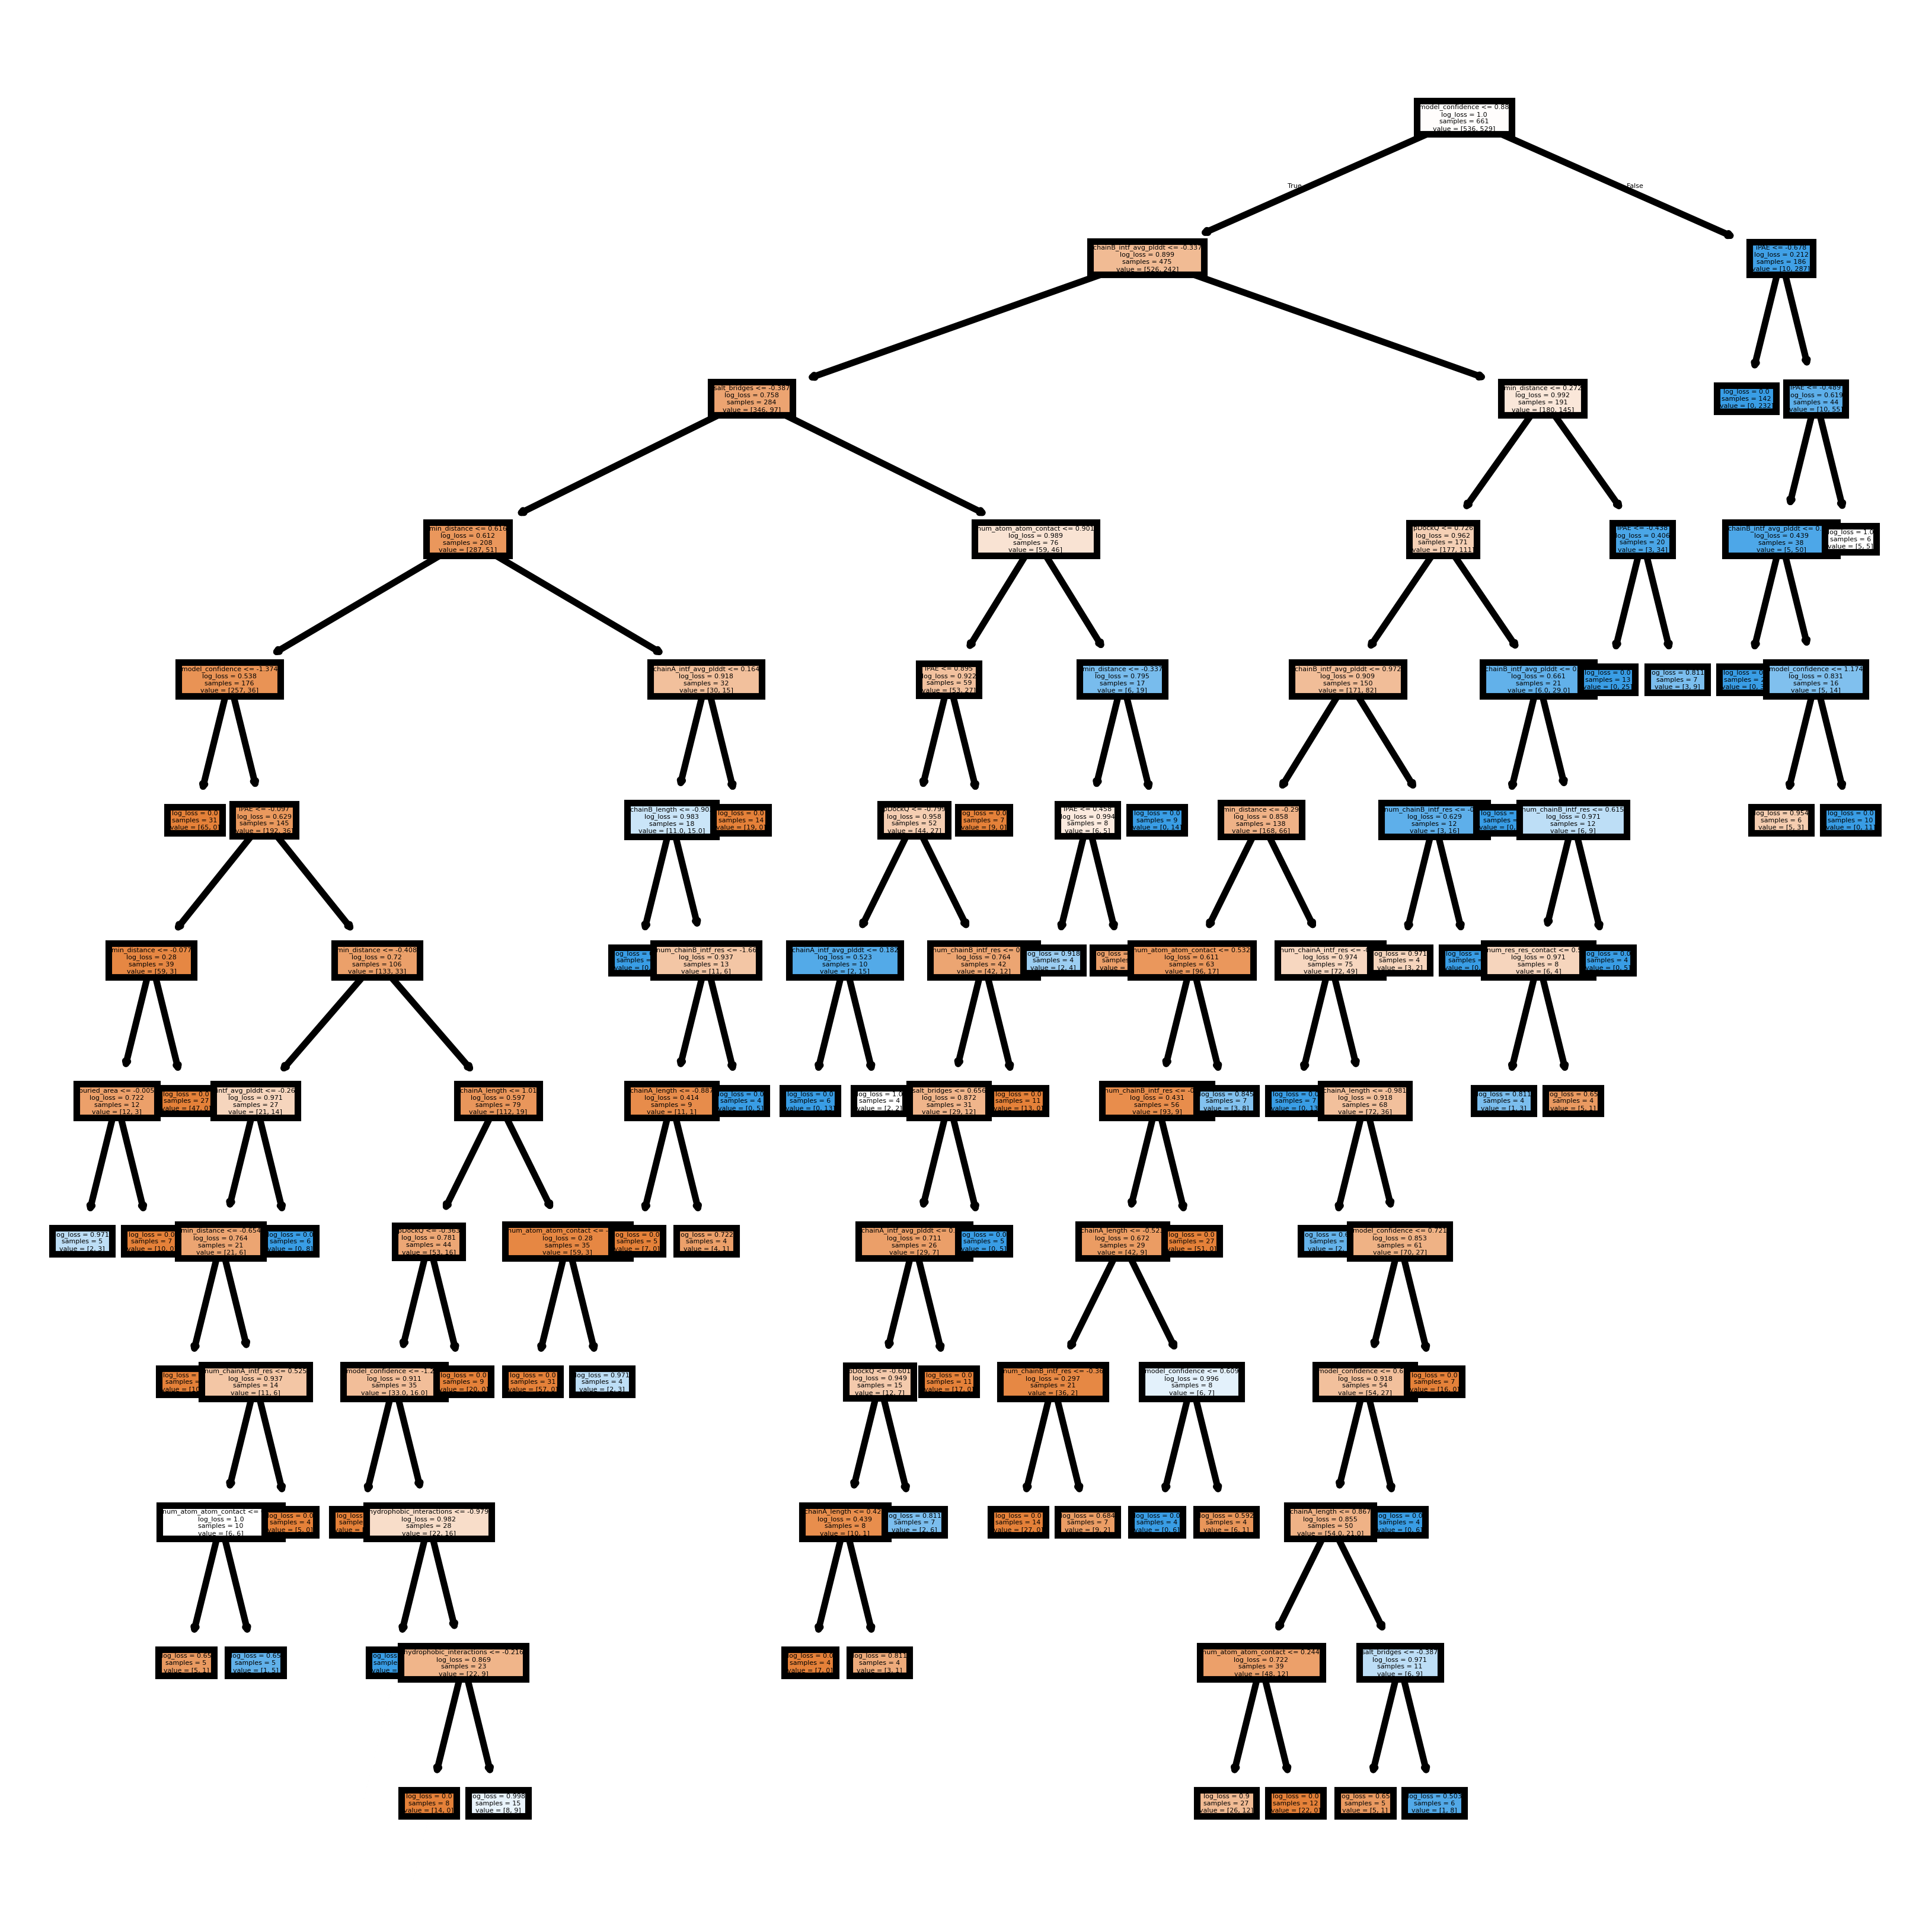

In [21]:
import sklearn.tree


fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=800)
sklearn.tree.plot_tree(rf_best.estimators_[0], feature_names=X.columns, filled=True)
plt.show()

## Tests

In [203]:
rf = RandomForestClassifier(n_estimators=250, random_state=2501)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=250, random_state=2501)

In [206]:
rf.max_samples

In [174]:
#fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (5,5), dpi=1500)
#sklearn.tree.plot_tree(rf.estimators_[0], feature_names=X.columns, filled=True)
#plt.show()W

In [107]:
y_pred = rf.predict(x_test)


In [207]:
rf.score(x_test, y_test)

0.850187265917603

In [ ]:
# ROC Curve



In [108]:
features ={k:v for k,v in zip(list(X.columns), rf.feature_importances_)}
features = {k:v for k,v in sorted(features.items(), key=lambda i: i[1], reverse=True)}
features

{'model_confidence': 0.1803008254805321,
 'iPAE': 0.14411239960106917,
 'chainB_intf_avg_plddt': 0.08767374817298779,
 'intf_avg_plddt': 0.07774256330417197,
 'pDockQ': 0.06747518669818155,
 'chainA_length': 0.05690482807695371,
 'chainA_intf_avg_plddt': 0.051567143229155746,
 'min_distance': 0.04859802462806843,
 'num_atom_atom_contact': 0.0465176001258805,
 'buried_area': 0.04070801897841065,
 'hydrophobic_interactions': 0.039229044649046606,
 'num_res_res_contact': 0.03655803291780192,
 'num_chainA_intf_res': 0.0354127443941317,
 'chainB_length': 0.02955014009512133,
 'hbonds': 0.024083003435183756,
 'num_chainB_intf_res': 0.018711823568380574,
 'salt_bridges': 0.014854872644922502}

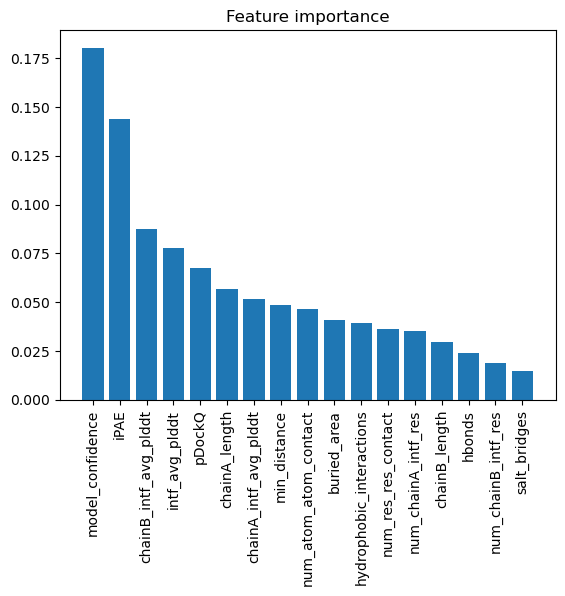

In [110]:
plt.title("Feature importance")
bar_chart = plt.bar(range(len(features)), features.values())
plt.xticks(range(len(features)), features.keys(), rotation=90)
plt.show()


Simple correlation tests

In [118]:
[X[x] for x in X.columns]

[0       312
 1       312
 2       312
 3       312
 4       312
        ... 
 1327    312
 1328    312
 1329    312
 1330    312
 1331    312
 Name: chainA_length, Length: 1332, dtype: int64,
 0       5
 1       5
 2       5
 3       5
 4       5
        ..
 1327    4
 1328    4
 1329    4
 1330    4
 1331    4
 Name: chainB_length, Length: 1332, dtype: int64,
 0       0.887117
 1       0.871984
 2       0.760784
 3       0.413662
 4       0.359078
           ...   
 1327    0.680386
 1328    0.674241
 1329    0.670584
 1330    0.635099
 1331    0.592737
 Name: model_confidence, Length: 1332, dtype: float64,
 0       96.107999
 1       95.793846
 2       95.547501
 3       94.646667
 4       94.830001
           ...    
 1327    94.414615
 1328    89.304167
 1329    90.133333
 1330    87.795000
 1331    92.550834
 Name: chainA_intf_avg_plddt, Length: 1332, dtype: float64,
 0       77.495999
 1       73.986000
 2       57.906001
 3       21.510000
 4       19.753333
           ...    


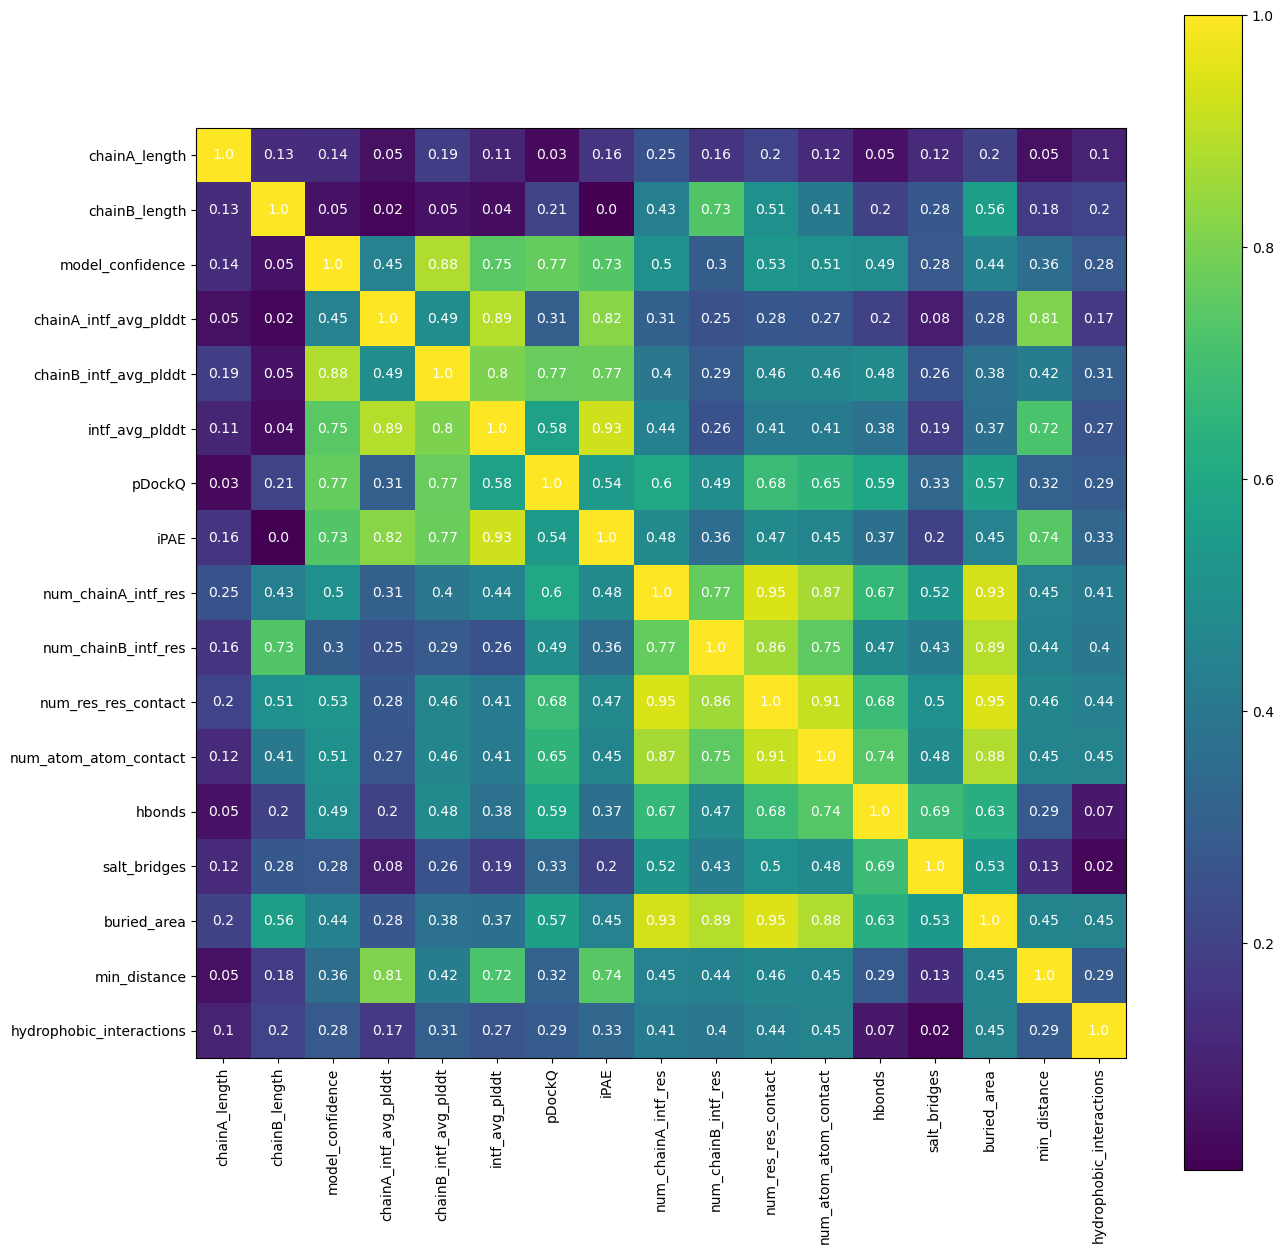

In [146]:
correlations = np.corrcoef([X[c] for c in X.columns])
correlations = np.abs(correlations)
plt.figure(figsize=(15,15))
ims = plt.imshow(correlations)
plt.colorbar(ims)
plt.xticks(range(len(X.columns)), labels=X.columns, rotation=90)
plt.yticks(range(len(X.columns)), labels=X.columns)
for i in range(len(X.columns)):
    for j in range(len(X.columns)):
        text = plt.text(j, i, round(correlations[i, j],2), ha="center", va="center", color="w")
plt.show()

In [147]:
correlations = np.corrcoef([X[c] for c in X.columns])
lcorr = {X.columns[i]: c for i, c in enumerate(correlations[2, :])}
lcorr = {k:v for k,v in sorted(lcorr.items(), key=lambda i: np.abs(i[1]), reverse=True)}
print(lcorr)
pd.DataFrame(lcorr.values(), index=lcorr.keys(), columns=["correlation coefficient"])

{'model_confidence': 1.0, 'chainB_intf_avg_plddt': 0.8830756883080768, 'pDockQ': 0.7659346264242626, 'intf_avg_plddt': 0.7459560519866867, 'iPAE': -0.7342680741418917, 'num_res_res_contact': 0.5260299538607066, 'num_atom_atom_contact': 0.5056655602257975, 'num_chainA_intf_res': 0.5048724969935294, 'hbonds': 0.4901413397693818, 'chainA_intf_avg_plddt': 0.4462506492865351, 'buried_area': 0.44346127973303534, 'min_distance': -0.35943618625513135, 'num_chainB_intf_res': 0.2998377048001385, 'hydrophobic_interactions': 0.2832484185533359, 'salt_bridges': 0.28297894135198615, 'chainA_length': 0.13579382153170144, 'chainB_length': -0.053197662510556805}


,correlation coefficient
model_confidence,1.000000
chainB_intf_avg_plddt,0.883076
pDockQ,0.765935
intf_avg_plddt,0.745956
iPAE,-0.734268
num_res_res_contact,0.526030
num_atom_atom_contact,0.505666
num_chainA_intf_res,0.504872
hbonds,0.490141
chainA_intf_avg_plddt,0.446251


In [135]:
correlations[0, 1:].shape

(17,)

## Logistic regression

In [154]:
lr_model = LogisticRegression()
lr_model.fit(x_train, y_train)

lr_model.score(x_test, y_test)

0.6704119850187266